## Clone the repository

In [1]:
!git clone https://github.com/apache/spark.git

Cloning into 'spark'...
remote: Enumerating objects: 326, done.
remote: Counting objects: 100% (326/326), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 573713 (delta 213), reused 128 (delta 122), pack-reused 573387
Receiving objects: 100% (573713/573713), 277.09 MiB | 1.14 MiB/s, done.
Resolving deltas: 100% (218538/218538), done.
Checking connectivity... done.


## Define function to detect identifier streams

In [2]:
import re

def extract_names(token):
    NAME_BREAKUP_RE = re.compile(r"[^a-zA-Z]+")
    token = token.strip()
    prev_p = [""]

    def ret(name):
        r = name.lower()
        if len(name) >= 3:
            yield r
            if prev_p[0]:
                yield prev_p[0] + r
                prev_p[0] = ""
        else:
            prev_p[0] = r

    for part in NAME_BREAKUP_RE.split(token):
        if not part:
            continue
        prev = part[0]
        pos = 0
        for i in range(1, len(part)):
            this = part[i]
            if prev.islower() and this.isupper():
                yield from ret(part[pos:i])
                pos = i
            elif prev.isupper() and this.islower():
                if 0 < i - 1 - pos <= 3:
                    yield from ret(part[pos:i - 1])
                    pos = i - 1
                elif i - 1 > pos:
                    yield from ret(part[pos:i])
                    pos = i
            prev = this
        last = part[pos:]
        if last:
            yield from ret(last)

In [3]:
import pygments
from pygments.formatter import Formatter
from pygments.lexers import get_lexer_for_filename
from pygments.token import Token

class FormatterProxy(Formatter):
    name = "Proxy"
    aliases = ["proxy"]
    filenames = []

    def __init__(self, **options):
        super(FormatterProxy, self).__init__(**options)
        self.callback = options["callback"]
        self.names = options["names"]

    def format(self, tokensource, outfile):
        self.callback(tokensource, self.names) 


        
def process_tokens(tokens, names):
    for _type, value in tokens:
        if _type[0] == "Name":
            for part in extract_names(value):
                names.append(part)


## Process files

Used the github-linguist to classify the files by the programming language. Then the most common programming language is selected and the files of this language are processed with Pygments.

In [4]:
import os

walk_dir = 'spark'
stemmed_root = 'stemmed_spark'
merged_file = 'name_tokens.txt'

In [5]:
%cd spark
!github-linguist --breakdown > most.txt

/home/paulbota/Documents/spark


In [6]:
!github-linguist --json > files.json

In [7]:
%cd ..
!mv spark/most.txt most.txt
!mv spark/files.json files.json

/home/paulbota/Documents


In [8]:
import json


with open('files.json') as f:
    data = json.load(f)
    
with open('most.txt') as m:
    most = m.readline()

language_name = most.split('%')[1].replace(' ', '').replace('\n', '')

files = data[language_name]

In [9]:
if not os.path.exists(stemmed_root):
    os.makedirs(stemmed_root)

with open(merged_file, 'w') as mf:    
    for file_path in files:
        filename = file_path.split('/')[-1]
        file_path = os.path.join(walk_dir, file_path)
        
        stemmed_file_path = os.path.join(stemmed_root, filename)

        with open(file_path, 'rb') as f:
            code = f.read()
            
            try:
                lexer = get_lexer_for_filename(filename, code)
                names = []
                pygments.highlight(code, lexer, FormatterProxy(callback=process_tokens, names=names))

                with open(stemmed_file_path, 'w') as sf:     
                    for name in names:
                        sf.write("%s " % name)
                        mf.write("%s " % name)
            except Exception as ex:
                print(ex)

no lexer for filename 'plugins.sbt' found


## Create the word2vec model

I decided to use word2vec from Google: https://github.com/danielfrg/word2vec (Python wrapper).
From trial and error I decided to use the min_count to 1000 in order to reduce the size of the vocabulary to improve the visualization.

In [10]:
import word2vec
word2vec_model_path = 'word2vec_model.bin'

word2vec.word2vec(merged_file, word2vec_model_path, size=100, min_count=1000, verbose=True)

Starting training using file name_tokens.txt
Vocab size: 324
Words in train file: 1152317
Alpha: 0.000002  Progress: 100.85%  Words/thread/sec: 603.93k  thread/sec: 600.52k  gress: 15.28%  Words/thread/sec: 608.69k  %  Words/thread/sec: 587.78k  thread/sec: 531.03k   Progress: 40.27%  Words/thread/sec: 555.18k  lpha: 0.012592  Progress: 49.82%  Words/thread/sec: 563.75k   573.73k  ec: 579.84k  530  Progress: 78.06%  Words/thread/sec: 590.79k  ress: 86.85%  Words/thread/sec: 592.19k  : 0.001359  Progress: 94.76%  Words/thread/sec: 597.93k  

## Create the t-SNE model

In [11]:
from sklearn.manifold import TSNE

model = word2vec.load(word2vec_model_path)

words = []
vectors = []

for word in model.vocab:
    vectors.append(model[word])
    words.append(word)

tsne = TSNE()
transformed_vectors = tsne.fit_transform(vectors)

## Visualize the data

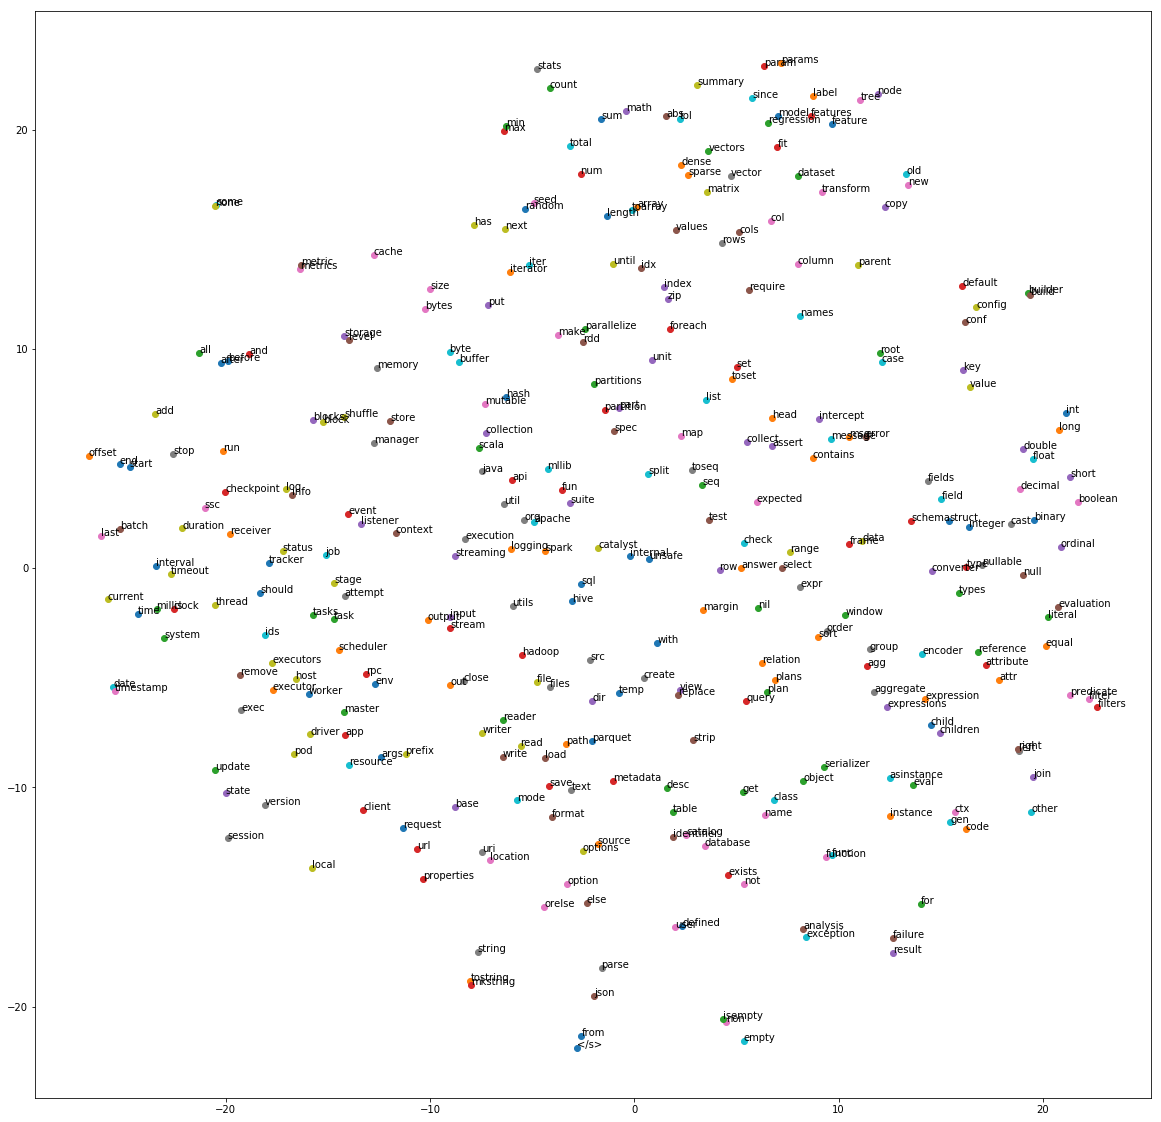

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20)) 
for i in range(len(transformed_vectors)):
    values = (transformed_vectors[i][0],transformed_vectors[i][1])
    plt.scatter(*values)
    plt.annotate(words[i], xy=values)
plt.show()

In the plot above the relations between the words in the vocanbulary are shown. The words that belong to the sames concept are close to each other. 

An expected thing is that the datatypes are close to each other, and we can also see that "int" is closer to "long" and "float" is closer to "double". I found interesting that this kind of relationships are shown. 

Another examples are the elements of an error: "error", "msg", "message" and "intercept". 

Variants of the word are very close to each other like: "file" - "files", "child" - "children" or "filter" - "filters". This is not always true as the word "row" is pretty far away from "rows", probably beeing used in different contexts.